<a href="https://colab.research.google.com/github/nekotanku/colab/blob/master/CNN_CIFAR10_%E3%83%87%E3%83%BC%E3%82%BF%E6%8B%A1%E5%BC%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
val_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
names = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
data_iter = iter(train_dataloader)
imgs, labels = data_iter.next()

In [ ]:
labels

tensor([9, 2, 8, 6, 2, 7, 1, 3, 2, 6, 6, 0, 9, 7, 4, 8, 3, 2, 4, 4, 0, 0, 6, 1,
        9, 5, 8, 6, 5, 5, 9, 5])

In [ ]:
imgs.size()

torch.Size([32, 3, 32, 32])

In [ ]:
img = imgs[0]

In [ ]:
img_permute = img.permute(1,2,0)
img_permute = 0.5 * img_permute + 0.5
img_permute = np.clip(img_permute, 0, 1)

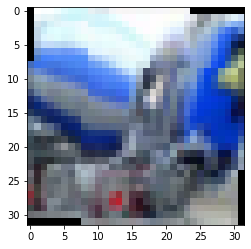

In [ ]:
plt.imshow(img_permute)

## CNNクラス定義

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features  = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [ ]:
model = CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [21]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    
    #validation 

    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in val_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(val_dataloader)
    val_running_acc /= len(val_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc:{},  val_loss: {},val_acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 0.9558626684674222, acc:0.6645273566246033,  val_loss: 0.8415700511429638,val_acc: 0.7114616632461548
epoch: 1, loss: 0.8370753281671728, acc:0.7078534960746765,  val_loss: 0.7966417378891771,val_acc: 0.7259384989738464
epoch: 2, loss: 0.7748242969209387, acc:0.728446900844574,  val_loss: 0.8600438214338626,val_acc: 0.7067691683769226
epoch: 3, loss: 0.7254119995535755, acc:0.7474008202552795,  val_loss: 0.6983669631587811,val_acc: 0.7576876878738403
epoch: 4, loss: 0.696060789209181, acc:0.7550783753395081,  val_loss: 0.7049913597754396,val_acc: 0.759085476398468
epoch: 5, loss: 0.6666072403400736, acc:0.7683741450309753,  val_loss: 0.6836442879308908,val_acc: 0.7659744024276733
epoch: 6, loss: 0.6489323405352297, acc:0.7743322253227234,  val_loss: 0.7024360258167925,val_acc: 0.7576876878738403
epoch: 7, loss: 0.6275805545040071, acc:0.7811300158500671,  val_loss: 0.7122433017998838,val_acc: 0.7592851519584656
epoch: 8, loss: 0.6111714852615113, acc:0.7842890024185181,

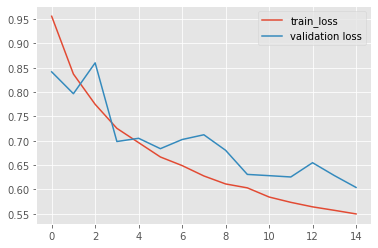

In [22]:
plt.style.use("ggplot")
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

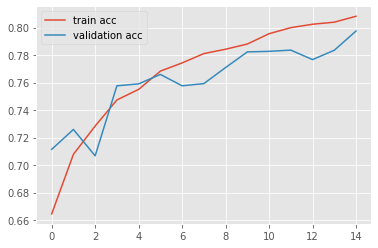

In [23]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()